In [1]:
import anndata
import scanpy as sc
import pandas as pd
import os
import hisepy

In [2]:
def read_adata_uuid(h5ad_uuid):
    h5ad_path = '/home/jupyter/cache/{u}'.format(u = h5ad_uuid)
    if not os.path.isdir(h5ad_path):
        hise_res = hisepy.reader.cache_files([h5ad_uuid])
    h5ad_filename = os.listdir(h5ad_path)[0]
    h5ad_file = '{p}/{f}'.format(p = h5ad_path, f = h5ad_filename)
    adata = sc.read_h5ad(h5ad_file)
    return adata

In [3]:
def read_obs_uuid(h5ad_uuid):
    h5ad_path = '/home/jupyter/cache/{u}'.format(u = h5ad_uuid)
    if not os.path.isdir(h5ad_path):
        hise_res = hisepy.reader.cache_files([h5ad_uuid])
    h5ad_filename = os.listdir(h5ad_path)[0]
    h5ad_file = '{p}/{f}'.format(p = h5ad_path, f = h5ad_filename)
    adata = sc.read_h5ad(h5ad_file, backed = 'r').obs.copy()
    return adata

In [4]:
def read_parquet_uuid(parquet_uuid):
    pq_path = '/home/jupyter/cache/{u}'.format(u = parquet_uuid)
    if not os.path.isdir(pq_path):
        hise_res = hisepy.reader.cache_files([parquet_uuid])
    pq_filename = os.listdir(pq_path)[0]
    pq_file = '{p}/{f}'.format(p = pq_path, f = pq_filename)
    df = pd.read_parquet(pq_file)
    return df

In [5]:
anno_cols = ['AIFI_L1', 'AIFI_L2', 'AIFI_L3']

In [6]:
cell_class = 'nk-cells'

## Read new subclustering results from HISE

In [7]:
new_h5ad_uuid = 'b2a3d1ba-312d-41ec-9e51-8ef4c33192fe'
new_adata = read_adata_uuid(new_h5ad_uuid)

In [79]:
new_pq_uuid = '97aafabe-8c6e-4001-8b1c-ad620738da63'
new_anno = read_parquet_uuid(new_pq_uuid)

In [81]:
new_anno = new_anno[[not x for x in new_anno['barcodes'].isin(dim_anno['barcodes'])]]
new_anno = pd.concat(
    [dim_anno[['barcodes', 'AIFI_L1', 'AIFI_L2', 'AIFI_L3']],
     new_anno[['barcodes', 'AIFI_L1', 'AIFI_L2', 'AIFI_L3']]]
)

KeyError: "['AIFI_L1', 'AIFI_L2', 'AIFI_L3'] not in index"

In [10]:
new_obs = new_adata.obs.copy()
new_obs = new_obs.reset_index(drop = True)
new_obs = new_obs.merge(new_anno, on = 'barcodes', how = 'left')
new_obs['AIFI_L1'] = new_obs['AIFI_L1'].astype('category')
new_obs['AIFI_L2'] = new_obs['AIFI_L2'].astype('category')
new_obs['AIFI_L3'] = new_obs['AIFI_L3'].astype('category')
new_obs = new_obs.set_index('barcodes', drop = False)

In [11]:
new_obs['AIFI_L1'].value_counts()

AIFI_L1
NK cell    160004
ILC           844
Name: count, dtype: int64

In [12]:
sum(new_obs['AIFI_L1'].isna())

0

In [13]:
new_anno.obs = new_obs

/tmp/ipykernel_12255/108851738.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  new_anno.obs = new_obs


/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


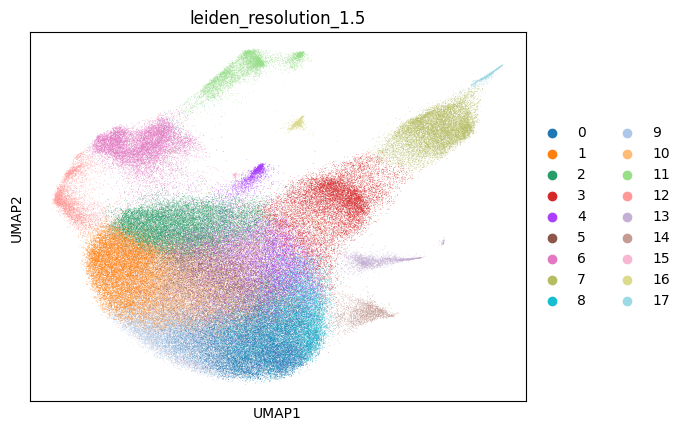

In [14]:
sc.pl.umap(
    new_adata,
    color = 'leiden_resolution_1.5'
)

In [15]:
temp_adata = anndata.AnnData(
    X = new_adata.X,
    obs = new_obs
)

In [16]:
new_adata.obs = temp_adata.obs

/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/opt/conda/lib/python3.10/site-packages/scanpy/plotting

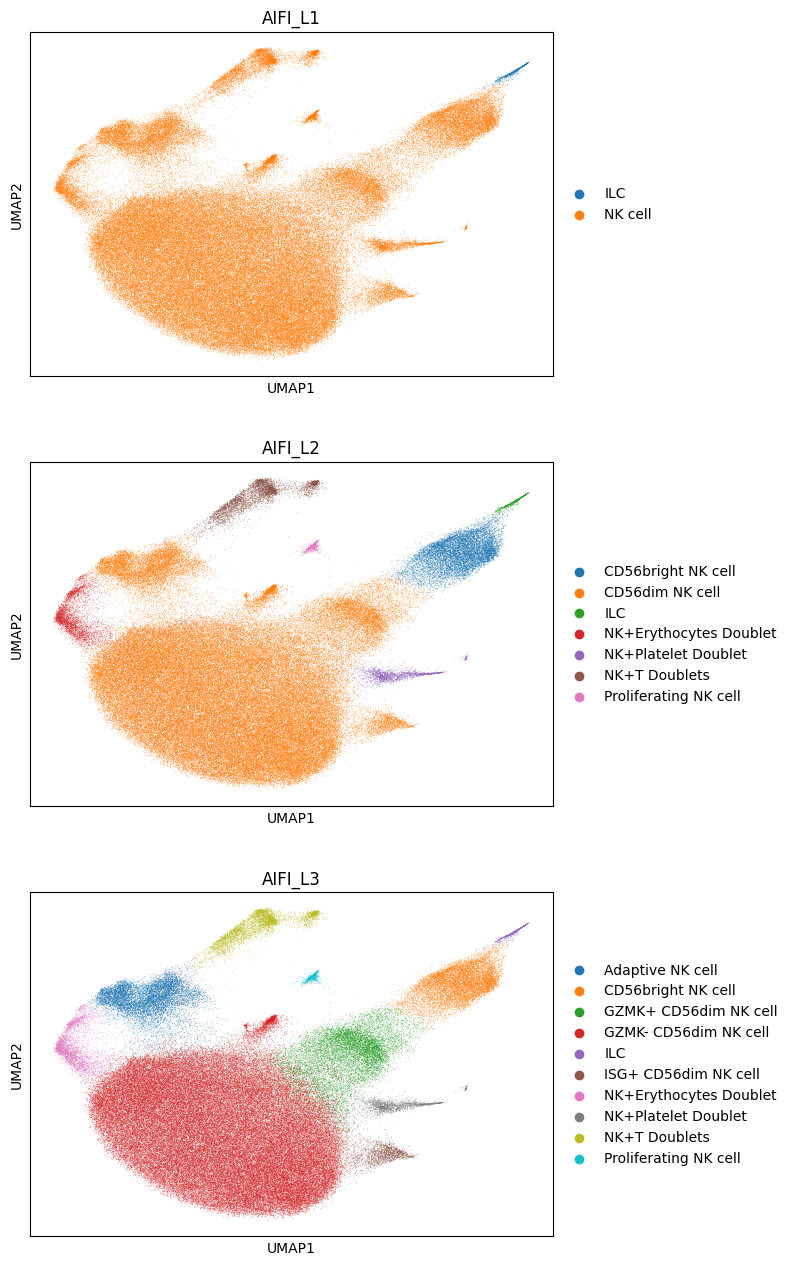

In [17]:
sc.pl.umap(
    new_adata,
    color = ['AIFI_L1', 'AIFI_L2', 'AIFI_L3'],
    ncols = 1
)

In [18]:
new_labels = new_adata.obs[['barcodes'] + anno_cols].copy()
for col in anno_cols:
    new_labels = new_labels.rename({col: 'new_' + col}, axis = 1)
new_labels = new_labels.reset_index(drop = True)

## Read old subclustering results from HISE

In [19]:
old_h5ad_uuid = '1bf187fb-d283-430e-9d1d-0d3ae199318e'
old_adata = read_adata_uuid(old_h5ad_uuid)

/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1897: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [20]:
old_anno = pd.read_csv('NK_Cells_Res1.5_Annotation.csv')

In [21]:
join_col = 'leiden_resolution_1.5'

In [22]:
old_anno[join_col] = old_anno[join_col].astype(str).astype('category')

In [23]:
old_adata.obs = old_adata.obs.merge(old_anno, on = join_col, how = 'left')

/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


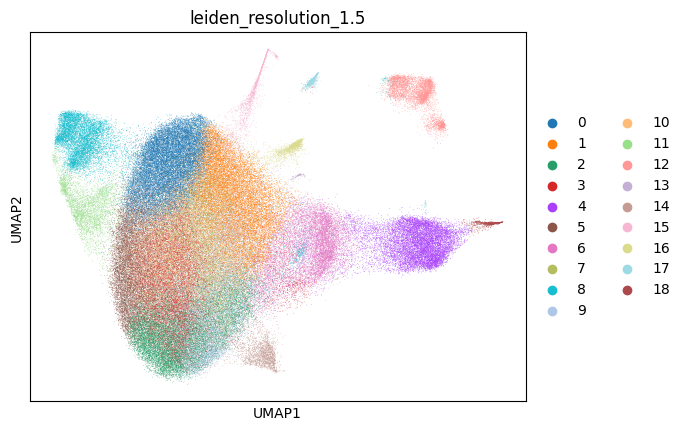

In [24]:
sc.pl.umap(
    old_adata,
    color = ['leiden_resolution_1.5'],
    ncols = 1
)

/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/opt/conda/lib/python3.10/site-packages/scanpy/plotting

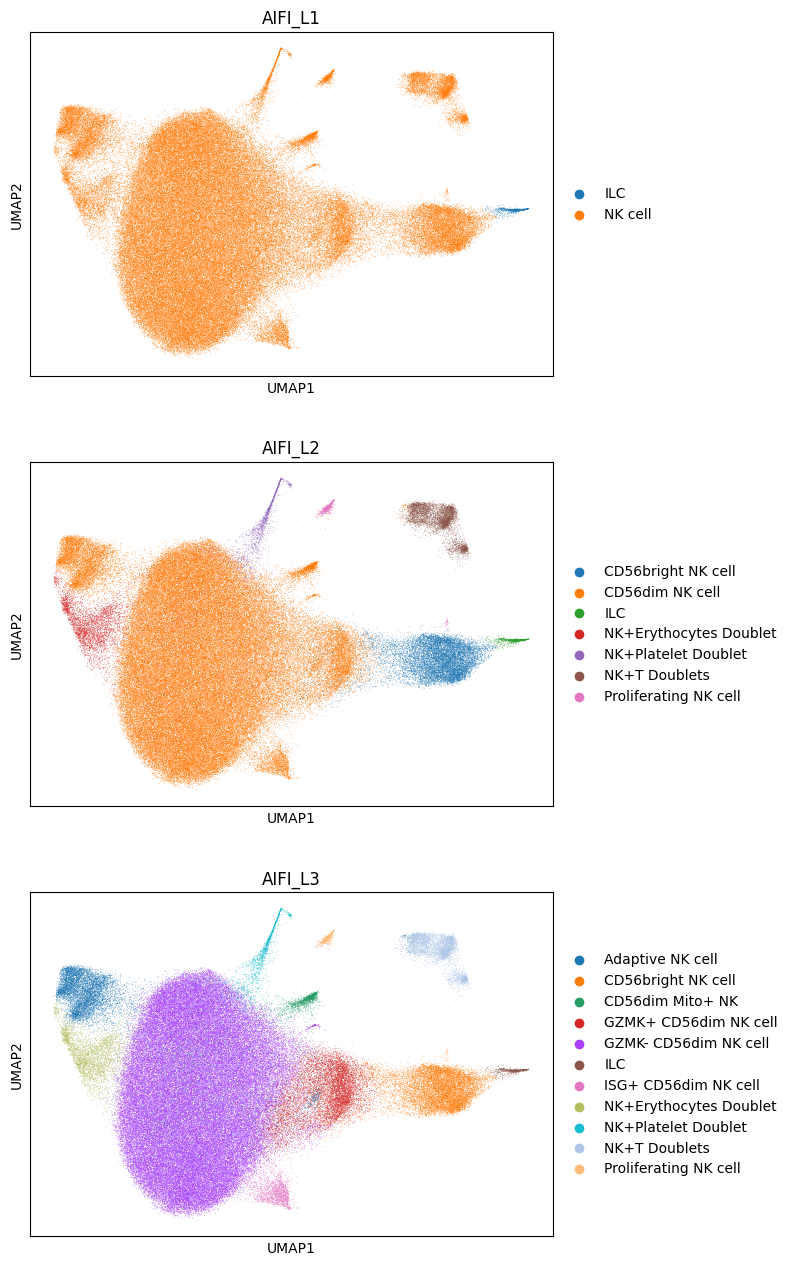

In [25]:
sc.pl.umap(
    old_adata,
    color = ['AIFI_L1', 'AIFI_L2', 'AIFI_L3'],
    ncols = 1
)

In [26]:
old_labels = old_adata.obs[['barcodes'] + anno_cols].copy()
for col in anno_cols:
    old_labels = old_labels.rename({col: 'old_' + col}, axis = 1)
old_labels = old_labels.reset_index(drop = True)

# Comparisons

In [27]:
comp = new_labels.merge(old_labels, on = 'barcodes', how = 'outer')

## L1 Comparison

In [28]:
level = 'L1'
new_col = 'new_AIFI_' + level
old_col = 'old_AIFI_' + level

In [29]:
comp[old_col] = comp[old_col].cat.add_categories(['Missing'])
comp[old_col] = comp[old_col].fillna('Missing')
comp[new_col] = comp[new_col].cat.add_categories(['Missing'])
comp[new_col] = comp[new_col].fillna('Missing')

How many barcodes were in this category in either of the two runs?

In [30]:
n_total = comp.shape[0]
n_total

161391

How many had identical assignments?

In [31]:
n_ident = sum(comp[old_col] == comp[new_col])
n_ident

158648

What fraction is that?

In [32]:
frac_ident = n_ident / n_total
frac_ident

0.983004008897646

What are the counts for each category in old and new annotations?

In [33]:
comp[old_col].value_counts()

old_AIFI_L1
NK cell    158363
Missing      2146
ILC           882
Name: count, dtype: int64

In [34]:
comp[new_col].value_counts()

new_AIFI_L1
NK cell    160004
ILC           844
Missing       543
Name: count, dtype: int64

What percentage of old labels changed?

In [35]:
(comp[new_col].value_counts() - comp[old_col].value_counts()) / comp[old_col].value_counts() * 100

ILC        -4.308390
NK cell     1.036227
Missing   -74.697111
Name: count, dtype: float64

Where there are mismatches, what were old labels changed to?

In [36]:
diff = comp[comp[old_col] != comp[new_col]]

In [37]:
diff[[old_col, new_col]].value_counts().head(20)

old_AIFI_L1  new_AIFI_L1
Missing      NK cell        2140
NK cell      Missing         537
ILC          NK cell          46
NK cell      ILC               8
ILC          Missing           6
Missing      ILC               6
Name: count, dtype: int64

Generate a plot on old coordinates showing where things differ

In [38]:
match_bc = comp['barcodes'][comp[old_col] == comp[new_col]].to_list()
match_lgl = old_adata.obs['barcodes'].isin(match_bc)
match_values = []
for lgl in match_lgl:
    if lgl:
        match_values.append('Match')
    else:
        match_values.append('Mismatch')

In [39]:
old_adata.obs['match'] = match_values
old_adata.obs['match'] = old_adata.obs['match'].astype('category')

/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/opt/conda/lib/python3.10/site-packages/scanpy/plotting

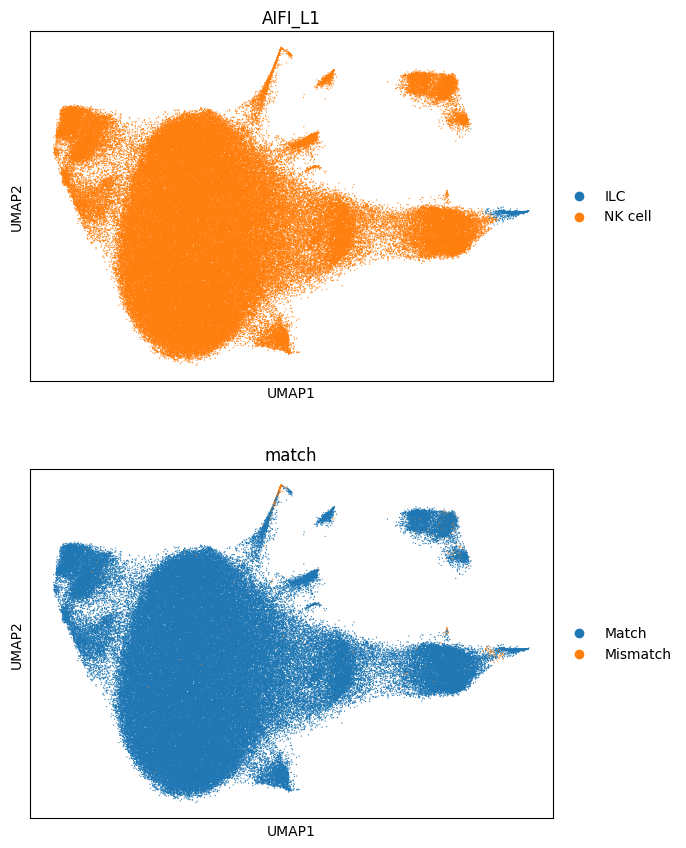

In [40]:
sc.pl.umap(
    old_adata,
    color = ['AIFI_L1', 'match'],
    ncols = 1,
    size = 3
)

Generate a plot on new coordinates showing where things differ

In [41]:
match_bc = comp['barcodes'][comp[old_col] == comp[new_col]].to_list()
match_lgl = new_adata.obs['barcodes'].isin(match_bc)
match_values = []
for lgl in match_lgl:
    if lgl:
        match_values.append('Match')
    else:
        match_values.append('Mismatch')

In [42]:
new_adata.obs['match'] = match_values
new_adata.obs['match'] = new_adata.obs['match'].astype('category')

/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/opt/conda/lib/python3.10/site-packages/scanpy/plotting

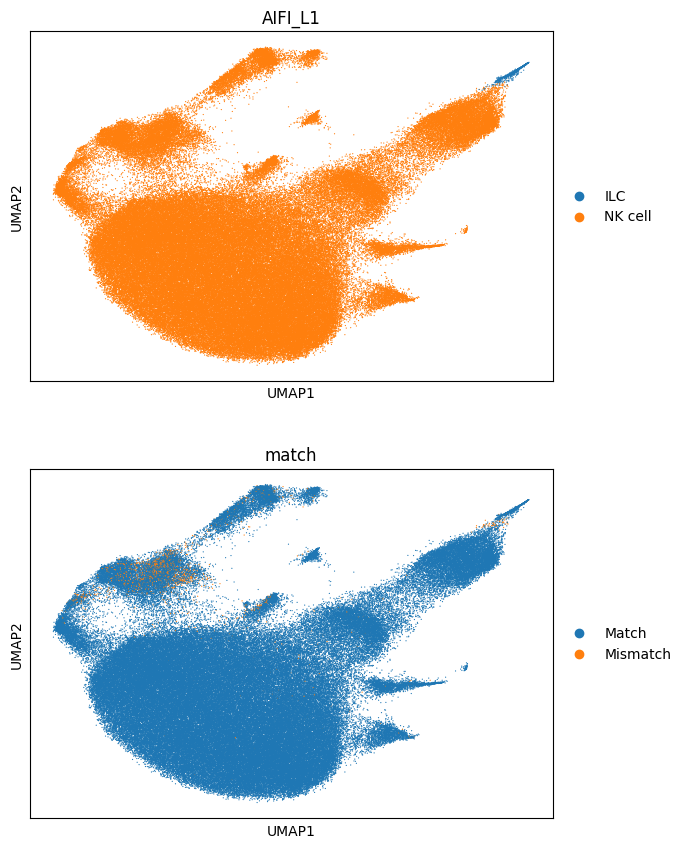

In [43]:
sc.pl.umap(
    new_adata,
    color = ['AIFI_L1', 'match'],
    ncols = 1,
    size = 3
)

## L2 Comparison

In [44]:
level = 'L2'
new_col = 'new_AIFI_' + level
old_col = 'old_AIFI_' + level

In [45]:
comp = new_labels.merge(old_labels, on = 'barcodes', how = 'outer')

In [46]:
comp[old_col] = comp[old_col].cat.add_categories(['Missing'])
comp[old_col] = comp[old_col].fillna('Missing')
comp[new_col] = comp[new_col].cat.add_categories(['Missing'])
comp[new_col] = comp[new_col].fillna('Missing')

How many barcodes were in this category in either of the two runs?

In [47]:
n_total = comp.shape[0]
n_total

161391

How many had identical assignments?

In [48]:
n_ident = sum(comp[old_col] == comp[new_col])
n_ident

154390

What fraction is that?

In [49]:
frac_ident = n_ident / n_total
frac_ident

0.9566208772484215

What are the counts for each category in old and new annotations?

In [50]:
comp[old_col].value_counts()

old_AIFI_L2
CD56dim NK cell           130850
CD56bright NK cell         12209
NK+Erythocytes Doublet      5549
NK+T Doublets               5412
NK+Platelet Doublet         3339
Missing                     2146
Proliferating NK cell       1004
ILC                          882
Name: count, dtype: int64

In [51]:
comp[new_col].value_counts()

new_AIFI_L2
CD56dim NK cell           133123
CD56bright NK cell         11055
NK+T Doublets               5494
NK+Erythocytes Doublet      5181
NK+Platelet Doublet         4214
Proliferating NK cell        937
ILC                          844
Missing                      543
Name: count, dtype: int64

What percentage of old labels changed?

In [52]:
(comp[new_col].value_counts() - comp[old_col].value_counts()) / comp[old_col].value_counts() * 100

CD56bright NK cell        -9.452044
CD56dim NK cell            1.737104
ILC                       -4.308390
NK+Erythocytes Doublet    -6.631826
NK+Platelet Doublet       26.205451
NK+T Doublets              1.515152
Proliferating NK cell     -6.673307
Missing                  -74.697111
Name: count, dtype: float64

Where there are mismatches, what were old labels changed to?

In [53]:
diff = comp[comp[old_col] != comp[new_col]]

In [54]:
diff[[old_col, new_col]].value_counts().head(20)

old_AIFI_L2             new_AIFI_L2           
Missing                 CD56dim NK cell           1720
CD56dim NK cell         NK+Platelet Doublet       1231
CD56bright NK cell      CD56dim NK cell           1216
NK+Erythocytes Doublet  CD56dim NK cell            842
CD56dim NK cell         NK+Erythocytes Doublet     357
NK+Platelet Doublet     Missing                    247
Missing                 NK+T Doublets              242
NK+T Doublets           Missing                    173
NK+Platelet Doublet     CD56dim NK cell            166
Missing                 NK+Erythocytes Doublet     156
CD56dim NK cell         NK+T Doublets              102
NK+T Doublets           CD56dim NK cell             86
Proliferating NK cell   CD56dim NK cell             74
CD56dim NK cell         Missing                     70
                        Proliferating NK cell       56
ILC                     CD56bright NK cell          45
NK+Erythocytes Doublet  NK+Platelet Doublet         33
Proliferating NK c

In [55]:
match_bc = comp['barcodes'][comp[old_col] == comp[new_col]].to_list()
match_lgl = old_adata.obs['barcodes'].isin(match_bc)
match_values = []
for lgl in match_lgl:
    if lgl:
        match_values.append('Match')
    else:
        match_values.append('Mismatch')

In [56]:
old_adata.obs['match'] = match_values
old_adata.obs['match'] = old_adata.obs['match'].astype('category')

/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/opt/conda/lib/python3.10/site-packages/scanpy/plotting

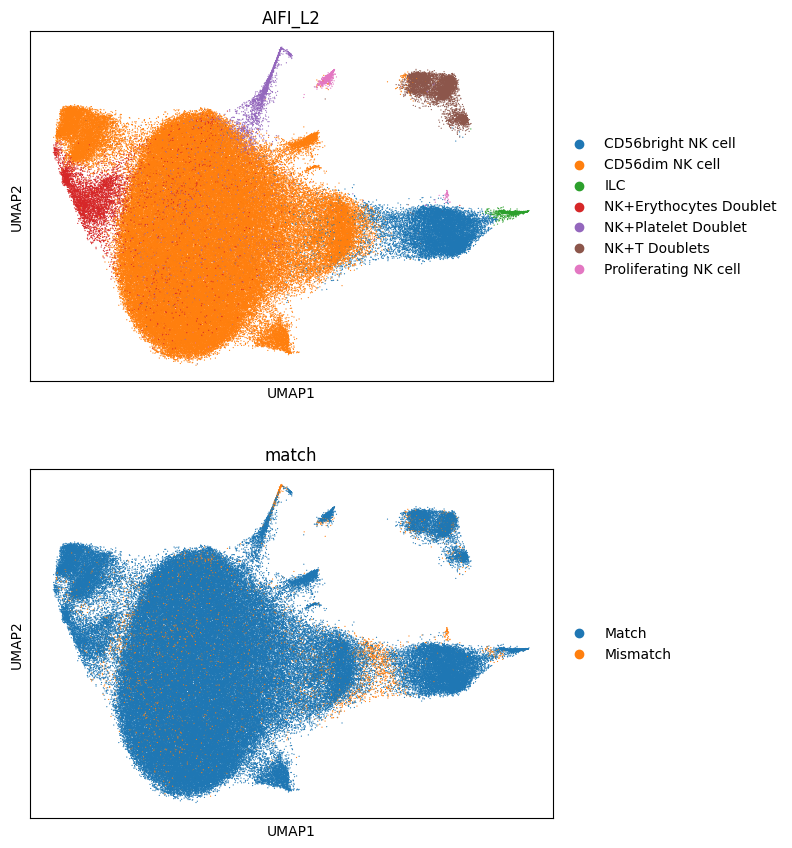

In [57]:
sc.pl.umap(
    old_adata,
    color = ['AIFI_L2', 'match'],
    ncols = 1,
    size = 3
)

Generate a plot on new coordinates showing where things differ

In [58]:
match_bc = comp['barcodes'][comp[old_col] == comp[new_col]].to_list()
match_lgl = new_adata.obs['barcodes'].isin(match_bc)
match_values = []
for lgl in match_lgl:
    if lgl:
        match_values.append('Match')
    else:
        match_values.append('Mismatch')

In [59]:
new_adata.obs['match'] = match_values
new_adata.obs['match'] = new_adata.obs['match'].astype('category')

/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/opt/conda/lib/python3.10/site-packages/scanpy/plotting

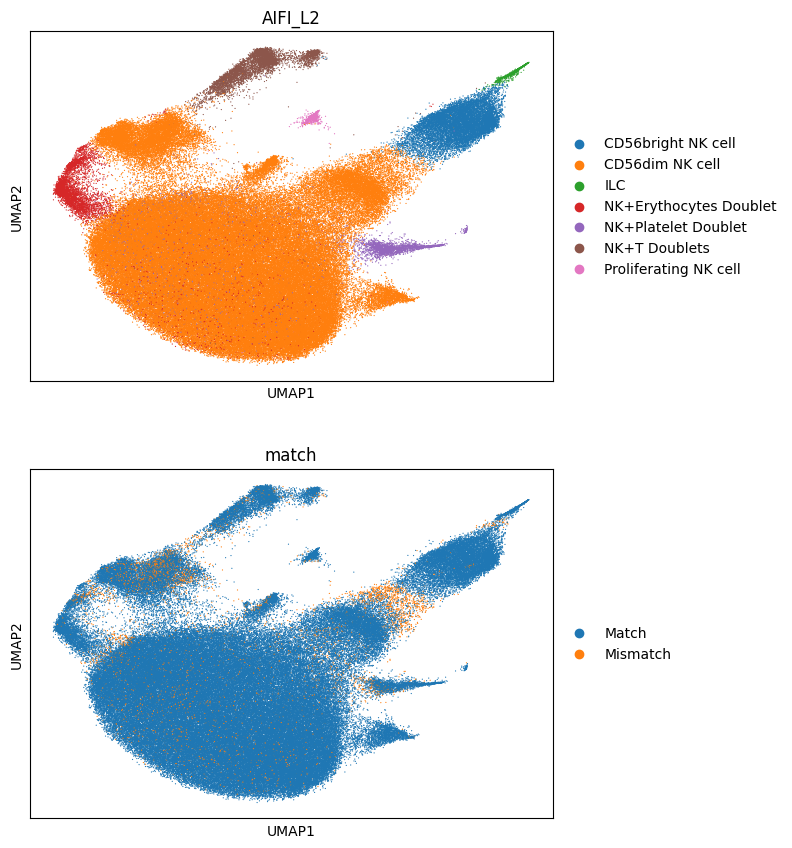

In [60]:
sc.pl.umap(
    new_adata,
    color = ['AIFI_L2', 'match'],
    ncols = 1,
    size = 3
)

## L3 Comparison

In [61]:
level = 'L3'
new_col = 'new_AIFI_' + level
old_col = 'old_AIFI_' + level

In [62]:
comp = new_labels.merge(old_labels, on = 'barcodes', how = 'outer')

In [63]:
comp[old_col] = comp[old_col].cat.add_categories(['Missing'])
comp[old_col] = comp[old_col].fillna('Missing')
old_cat = comp[old_col].cat.categories
comp[new_col] = comp[new_col].cat.set_categories(old_cat)
comp[new_col] = comp[new_col].fillna('Missing')

How many barcodes were in this category in either of the two runs?

In [64]:
n_total = comp.shape[0]
n_total

161391

How many had identical assignments?

In [65]:
n_ident = sum(comp[old_col] == comp[new_col])
n_ident

145461

What fraction is that?

In [66]:
frac_ident = n_ident / n_total
frac_ident

0.9012956112794394

What are the counts for each category in old and new annotations?

In [67]:
comp[old_col].value_counts()

old_AIFI_L3
GZMK- CD56dim NK cell     103311
CD56bright NK cell         12209
GZMK+ CD56dim NK cell      10478
Adaptive NK cell            9946
NK+Erythocytes Doublet      5549
NK+T Doublets               5412
ISG+ CD56dim NK cell        3834
NK+Platelet Doublet         3339
CD56dim Mito+ NK            3281
Missing                     2146
Proliferating NK cell       1004
ILC                          882
Name: count, dtype: int64

In [68]:
comp[new_col].value_counts()

new_AIFI_L3
GZMK- CD56dim NK cell     105676
GZMK+ CD56dim NK cell      12752
Adaptive NK cell           11209
CD56bright NK cell         11055
NK+T Doublets               5494
NK+Erythocytes Doublet      5181
NK+Platelet Doublet         4214
ISG+ CD56dim NK cell        3486
Proliferating NK cell        937
ILC                          844
Missing                      543
CD56dim Mito+ NK               0
Name: count, dtype: int64

What percentage of old labels changed?

In [69]:
(comp[new_col].value_counts() - comp[old_col].value_counts()) / comp[old_col].value_counts() * 100

Adaptive NK cell           12.698572
CD56bright NK cell         -9.452044
CD56dim Mito+ NK         -100.000000
GZMK+ CD56dim NK cell      21.702615
GZMK- CD56dim NK cell       2.289204
ILC                        -4.308390
ISG+ CD56dim NK cell       -9.076682
NK+Erythocytes Doublet     -6.631826
NK+Platelet Doublet        26.205451
NK+T Doublets               1.515152
Proliferating NK cell      -6.673307
Missing                   -74.697111
Name: count, dtype: float64

Where there are mismatches, what were old labels changed to?

In [70]:
diff = comp[comp[old_col] != comp[new_col]]

In [71]:
diff[[old_col, new_col]].value_counts().head(20)

old_AIFI_L3             new_AIFI_L3           
CD56dim Mito+ NK        GZMK- CD56dim NK cell     3227
GZMK- CD56dim NK cell   GZMK+ CD56dim NK cell     2074
Missing                 Adaptive NK cell          1436
CD56bright NK cell      GZMK+ CD56dim NK cell     1191
GZMK- CD56dim NK cell   NK+Platelet Doublet       1120
GZMK+ CD56dim NK cell   GZMK- CD56dim NK cell     1041
Adaptive NK cell        GZMK- CD56dim NK cell      773
NK+Erythocytes Doublet  GZMK- CD56dim NK cell      766
ISG+ CD56dim NK cell    GZMK- CD56dim NK cell      635
GZMK- CD56dim NK cell   Adaptive NK cell           620
                        ISG+ CD56dim NK cell       320
                        NK+Erythocytes Doublet     274
NK+Platelet Doublet     Missing                    247
Missing                 NK+T Doublets              242
                        GZMK- CD56dim NK cell      212
NK+T Doublets           Missing                    173
Missing                 NK+Erythocytes Doublet     156
NK+Platelet Double

In [72]:
match_bc = comp['barcodes'][comp[old_col] == comp[new_col]].to_list()
match_lgl = old_adata.obs['barcodes'].isin(match_bc)
match_values = []
for lgl in match_lgl:
    if lgl:
        match_values.append('Match')
    else:
        match_values.append('Mismatch')

In [73]:
old_adata.obs['match'] = match_values
old_adata.obs['match'] = old_adata.obs['match'].astype('category')

/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/opt/conda/lib/python3.10/site-packages/scanpy/plotting

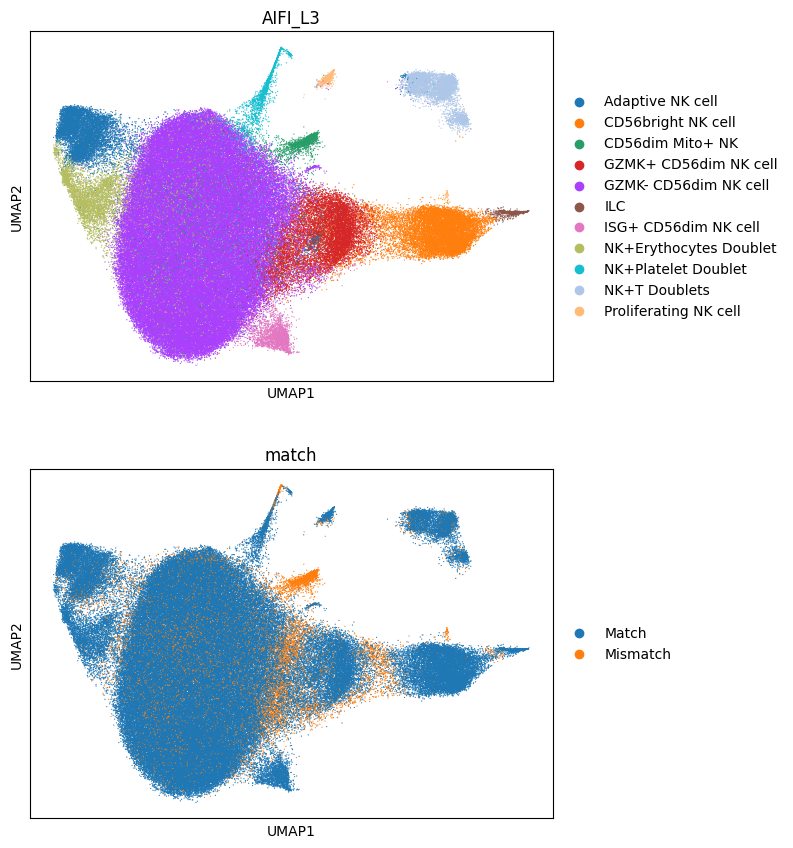

In [74]:
sc.pl.umap(
    old_adata,
    color = ['AIFI_L3', 'match'],
    ncols = 1,
    size = 3
)

Generate a plot on new coordinates showing where things differ

In [75]:
match_bc = comp['barcodes'][comp[old_col] == comp[new_col]].to_list()
match_lgl = new_adata.obs['barcodes'].isin(match_bc)
match_values = []
for lgl in match_lgl:
    if lgl:
        match_values.append('Match')
    else:
        match_values.append('Mismatch')

In [76]:
new_adata.obs['match'] = match_values
new_adata.obs['match'] = new_adata.obs['match'].astype('category')

/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/opt/conda/lib/python3.10/site-packages/scanpy/plotting

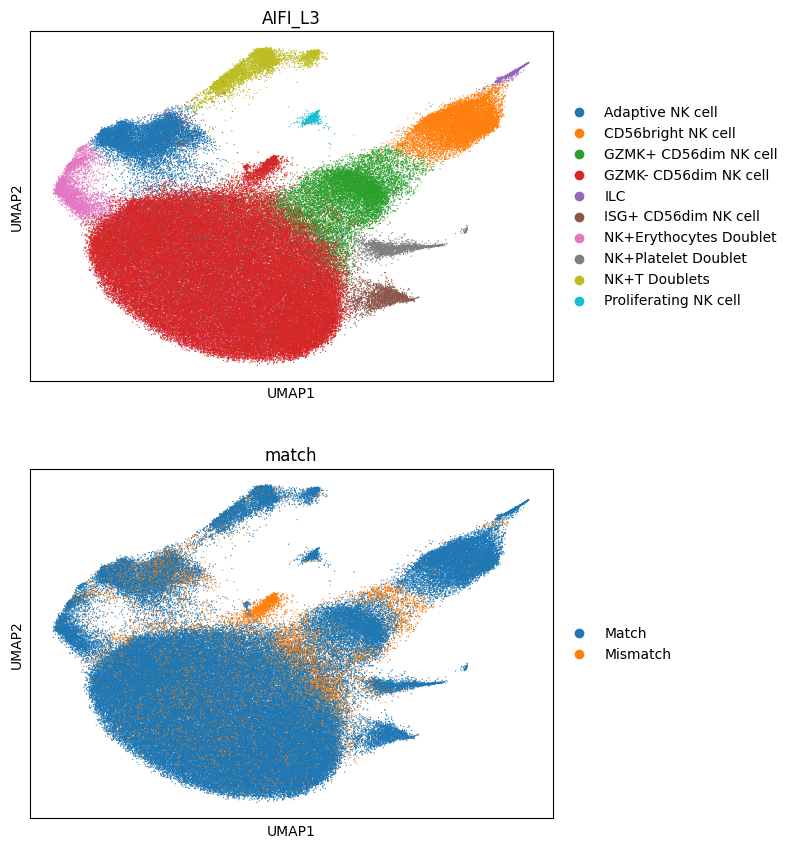

In [77]:
sc.pl.umap(
    new_adata,
    color = ['AIFI_L3', 'match'],
    ncols = 1,
    size = 3
)